In [141]:
import io
from collections import defaultdict

import chess
import chess.pgn
import chess.engine

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [27]:
from analysis_utils import get_first_move_with_bad_move, get_all_losses_for_my_moves, get_move
from local_data_manager import get_all_games

In [21]:
games = get_all_games('chessprimes', None, download=False, parse=False, analysis_time=0.25)

In [22]:
def get_total_number_moves(game):
    i = 0
    while len(game.variations):
        i += 1
        game = game.variations[0]
    return i

In [23]:
num_moves = list(map(get_total_number_moves, games))

In [24]:
print(f"on average total half moves is {sum(num_moves)/len(num_moves)}")

on average total half moves is 71.10741510741511


In [34]:
games[31].headers

Headers(Event='?', Site='https://lichess.org/2K0M7VUD', Date='2021-01-02 21:51:24.261000+00:00', Round='?', White='ziata', Black='chessprimes', Result='*')

-301


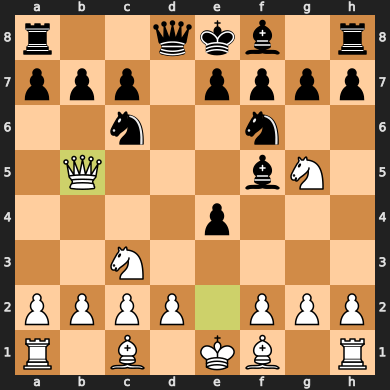

In [41]:
game = games[31]
move_num = 11
move = get_move(game, move_num)
print(move.eval())
move.board()

In [123]:
moves = []
diffs = []
checkmate_moves = []
no_data_moves = []
for i, game in enumerate(games):
    move_num, diff = get_first_move_with_bad_move(game, 'chessprimes', min_rating=-175, max_rating=175)
    if diff is None:
        no_data_moves.append(i)
        continue
    if diff == float('inf'):
        checkmate_moves.append(i)
        continue
    moves.append(move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1)
    diffs.append(diff)

In [125]:
print(f"On average I lose {sum(diffs)/len(diffs)} to go into a bad position on my {sum(moves)/len(moves)}'th move'")

On average I lose 245.0403162055336 to go into a bad position on my 13.793675889328064'th move'


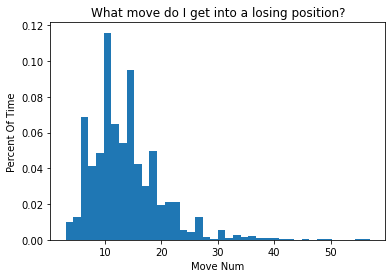

In [138]:
plt.hist(moves, density=True, bins=40)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("What move do I get into a losing position?")
plt.savefig('percent_move_losing.png')

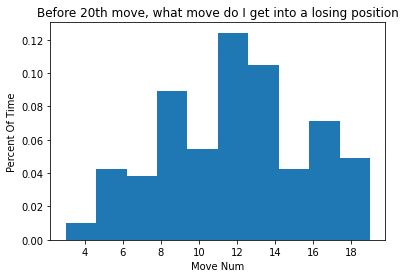

In [132]:
plt.hist(list(filter(lambda m: m < 20, moves)), density=True, bins=10)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("Before 20th move, what move do I get into a losing position");

In [192]:
d_set = defaultdict(list)
for move_num, diff in zip(moves, diffs):
    d_set[move_num].append(diff)
datas = []
for move_num, idv_diffs in d_set.items():
    datas.append(
        {
            'move_num': move_num,
            'avg_loss': sum(idv_diffs)/len(idv_diffs),
            'total_moves': len(idv_diffs)
        }
    )

In [193]:
data = pd.DataFrame(datas).sort_values(by='move_num')

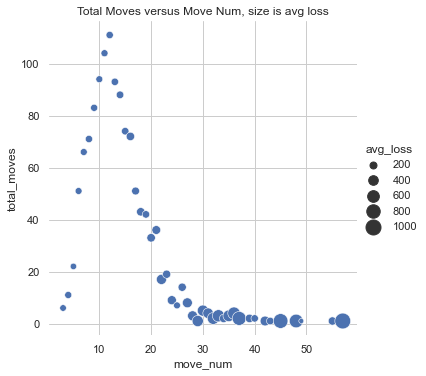

In [194]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss')
plt.savefig('images/replotavg_total_moves_versus_move_num.png');

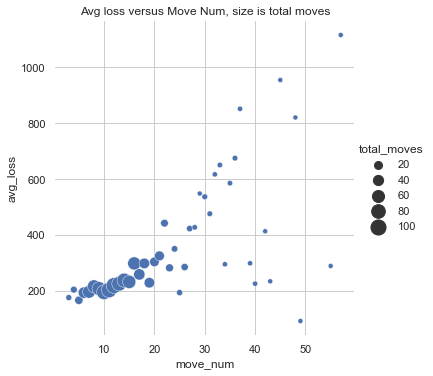

In [195]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves')
plt.savefig('images/replotavg_loss_versus_move_num.png');

In [183]:
game.headers

Headers(Event='?', Site='https://lichess.org/i2KnIEpr', Date='2018-12-04 18:07:47.168000+00:00', Round='?', White='chessprimes', Black='syolcu', Result='*')

In [209]:
data_buckets = defaultdict(list)
data_buckets_inf = defaultdict(int)
for game in games:
    for move_num, loss in get_all_losses_for_my_moves(game, 'chessprimes'):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        if loss == float('inf'):
            data_buckets_inf[move_num] += 1
        else:
            data_buckets[move_num].append(loss if loss >= 20 else 0)  # appending zero for near-perfect moves, especially because analysis was only 0.25 seconds
        
datas = []
for move_num, losses in data_buckets.items():
    datas.append({
        'move_num': move_num,
        'avg_loss': sum(losses)/len(losses),
        'total_moves': len(losses)
    })
datas = pd.DataFrame(datas)
datas_inf = []
for move_num, num_losses in data_buckets_inf.items():
    datas_inf.append({
        'move_num': move_num,
        'avg_loss': float('inf'),
        'total_moves': num_losses
    })
datas_inf = pd.DataFrame(datas_inf)

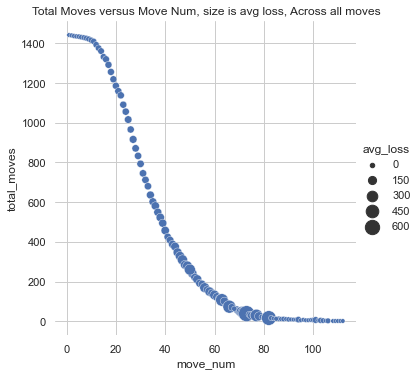

In [213]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss, Across all moves')
plt.savefig('images/replotavg_total_moves_versus_move_num_all_moves_loss.png');

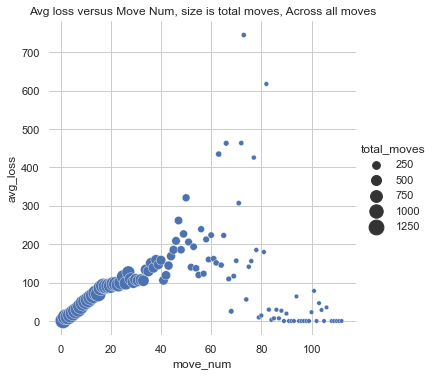

In [218]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves, Across all moves')
plt.savefig('images/replotavg_avg_loss_versus_move_num_all_moves.png');

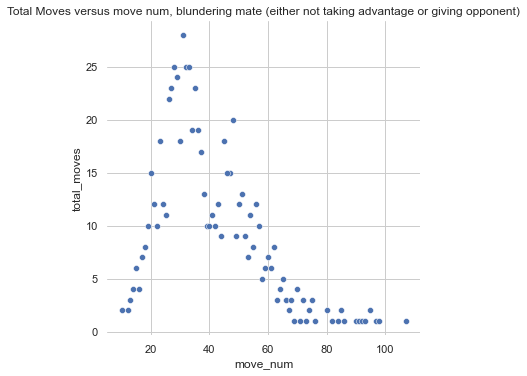

In [222]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas_inf,
    x="move_num", y="total_moves",
#     size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, blundering mate (either not taking advantage or giving opponent)')
plt.savefig('images/blundering_mate.png');